## PyHelios Avanzado

Se propone el siguiente ejercicio que mezcla los distintos conceptos aprendidos en los bloques HELIOS básico, avanzado y PyHelios.

### Modelo general

Sea un coche $(x(t), y(t), z(t)) = (x(t), 50, 0)$ que se mueve en la dirección del eje $\pmb{e_1}$ de la base canónica en el espacio Euclídeo (eje $x$). Se considera la posición inicial del coche como $x(0)=-100\;\mathrm{m}$ y la final como $x(t_*+T)=100\;\mathrm{m}$, siendo $v^* \in \mathbb{R}_{>0}$ la velocidad máxima que éste puede alcanzar. El valor $t_*\in\mathbb{R}_{>0}$ antes mencionado correspondería al momento en que comienza la desaceleración y $T\in\mathbb{R}_{>0}$ a la duración de la fase de desaceleración desde $v^*$ hasta cero. Además, puede hablarse de $t^*=0+T=T$ como el instante en el que termina de acelerar el coche desde cero hasta $v^*$, ya que se presupone que se acelera y desacelera con el siguiente modelo (donde $\lambda \in \mathbb{R}_{>0}$ da la pendiente de la aceleración/desaceleración lineal):

$$
\left\{\begin{split}
a(t) =&\; \lambda t &\;,\quad& t \leq t^* \\
a(t) =&\; 0 &\;,\quad& t^* < t < t_* \\
a(t) =&\; -\lambda (t-t_*) &\;,\quad& t_* \leq t \leq t_*+T
\end{split}\right.
$$

El cual debe satisfacer:

$$
v(0) = 0 \;,\quad v(t^* < t < t_*) = v^* \;,\quad v(t_*+T) = 0
$$

### Modelo de simulación

Supóngase $T=5$ segundos y $v^* = 10\;\mathrm{m}/\mathrm{s}$ e impleméntese el coche utilizando movimientos rígidos con $100$ traslaciones por segundo y un KDTree que se actualice $25$ veces por segundo. Colóquese un escáner terrestre RIEGL VZ-400 trucado para poder girar hasta $360\,^\circ/\mathrm{s}$ en un trípode en la posición $(0, 0, 0)$ mirando en la dirección $(0, 1)$ con un campo de visión horizontal entre los $[-30, 30]$ grados y un campo de visión vertical entre los $[-10, 10]$ grados. El escáner debe realizar $100$ scanlines por segundo de $1,000$ pulsos cada una. El escáner debe hacer tantos barridos como sea necesario para cubrir los $t_* + T$ segundos que dura el movimiento del coche. Además, deben colocarse dos RIEGL VZ-400 similares al original pero a mayores (*Pista: Configurarlo como un escáner multicanal*). El primero estára colocado $+(-1, -0.5)$ respecto de la posición del original y rotado en $55$ grados alrededor del eje $z$. El segundo estará colocado $+(1.0, -0.5)$ respecto de la posición del original y rotado en $-55$ grados alrededor del eje $z$. Por conveniencia, debe fijarse que el tiempo de inicio de la simulación es el segundo cero.

### Estudio comparativo

Comparar la velocidad estimada de cada coche en el tiempo a partir de la nube simulada con la velocidad del modelo analítico. 

1. Variando el número de barridos por segundo.
2. Variando la distancia en el plano entre el LiDAR a lo largo del eje $y$.
3. Variando el tamaño del coche.

De la anterior comparativa buscar el mejor resultado en términos de error cuadrático promedio y completar el estudio conservando constantes sus parámetros pero:

3. Variando la velocidad máxima del vehículo.

Para estimar la velocidad de los coches en la nube se divide la distancia Euclídea entre el centro a lo largo del eje $x$ entre escaneos consecutivos, entre la diferencia de los centros temporales.

In [1]:
# Configurar entorno Jupyter
%config Completer.use_jedi = False

# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import time

# Importar pyhelios
PYHELIOS_LIB_PATH = '/home/uadmin/git/helios/cmake-build-release'
HELIOS_PATH = '/home/uadmin/git/helios'
sys.path.append(PYHELIOS_LIB_PATH)
sys.path.append(HELIOS_PATH)
if os.getcwd().endswith('pyhelios'):
    os.chdir(os.path.dirname(os.getcwd()))
import pyhelios

In [2]:
# TODO : Codifica aquí la solución al ejercicio

## Solución

A continuación, se ofrece una posible solución al ejercicio propuesto.

### Implementando el modelo

En primer lugar, se implementa el modelo.

La velocidad se determina teniendo en cuenta que:

$$
v(t) = \int{a(t) dt}
$$

La posición debe ser:

$$
x(t) = \int{v(t) dt}
$$


Entonces, cuando $0 \leq t \leq t^*$:

$$
a(t) = \lambda t \;,\quad
v(t) = \dfrac{\lambda}{2} t^2 \;,\quad
x(t) = \frac{\lambda}{6} t^3
$$

Cuando $t^* < t < t_*$:

$$
a(t) = 0 \;,\quad
v(t) = v^* \;,\quad
x(t) = x(t^*) + (t-t^*)v^*
$$

Cuando $t_* \leq t \leq t_*+T$, siendo $\tau = t-t_*$:

$$
\begin{split}
a(t) = a(\tau) =&\;
    - \lambda (t-t_*) \\
v(t) = v(\tau) =&\; 
    \int{\left({- \lambda \tau}\right)d\tau} =
    v^* - \dfrac{\lambda}{2} \tau^2 =
    v^* - \dfrac{\lambda}{2} \left(t-t_*\right)^2 \\
x(t) = x(\tau) =&\;
    \int{\left({v^* - \dfrac{\lambda}{2}\tau^2}\right) d\tau} =
    x(t_*) + v^*\tau - \dfrac{\lambda}{6} \tau^3 =
    x(t_*) + v^*(t-t_*) - \dfrac{\lambda}{6} \left(t-t_*\right)^3
\end{split}
$$

Falta resolver para $\lambda$ y para $t_*$, para ello conviene recordar que $t^* = T$. Empezando por $\lambda$:

$$
v(t^*) = \dfrac{\lambda}{2}(t^*)^2 = v^* \iff 
    \lambda = \dfrac{2v^*}{(t^*)^2} = \dfrac{2v^*}{T^2}
$$

Para este caso, $T=5\;\mathrm{s}$ y $v^* = 10\; \mathrm{m}/\mathrm{s}$, por lo que $\lambda = 0.8$.

Terminando por $t_*$ y notando por $D$ la distancia máxima:

$$
x(t_*+T) = 
    x(t_*+t^*) = 
    x(t_*) + v^*t^* - \dfrac{\lambda}{6}(t^*)^3 =
    (t_* - t^*)v^* + v^*t^* = 
    D \iff
    t_* = \dfrac{D}{v^*}
$$

En este caso $D=200\;\mathrm{m}$ por lo que $t_* = 20\;\mathrm{s}$.

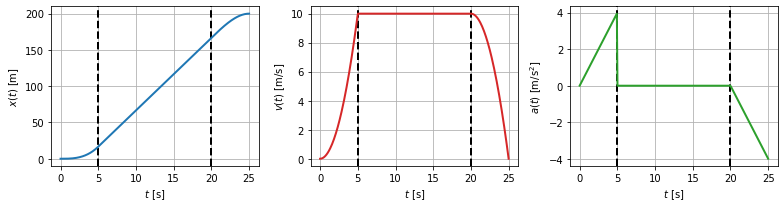

In [3]:
# ---  FASE DE ACELERACIÓN  --- #
# ----------------------------- #
def accel_a(t, lamb):
    return lamb*t

def accel_v(t, lamb):
    return lamb/2*t*t

def accel_x(t, lamb):
    return lamb/6*t*t*t


# ---  FASE DE VIAJE  --- #
# ----------------------- #
def travel_a(t):
    return 0

def travel_v(t, vmax):
    return vmax

def travel_x(t, lamb, t_accel, vmax):
    return accel_x(t_accel, lamb) + (t-t_accel)*vmax


# ---  FASE DE DESACELERACIÓN  --- #
# -------------------------------- #
def decel_a(t, lamb, t_decel, vmax):
    return -lamb*(t-t_decel)

def decel_v(t, lamb, t_decel, vmax):
    return vmax - lamb/2*(t-t_decel)**2

def decel_x(t, lamb, t_accel, t_decel, vmax):
    return (
        travel_x(t_decel, lamb, t_accel, vmax) +  # x(t_*) +
        vmax * (t-t_decel) -  # v^* (t-t_*) -
        lamb/6*(t-t_decel)**3  # lambda/6 (t-t_*)^3
    )
    
# ---  MODELO GENERAL  --- #
# ------------------------ #
MODELO_DISTANCIA = 200  # m
MODELO_T = 5.0  # s
MODELO_vmax = 10.0  # m/s
MODELO_lambda = 2*MODELO_vmax / (MODELO_T * MODELO_T)  # m/s^3
MODELO_DISTANCIA_T = MODELO_lambda/6 * MODELO_T*MODELO_T*MODELO_T  # m, x(t^*)
MODELO_t_decel = MODELO_DISTANCIA / MODELO_vmax  # s
MODELO_t_start = 0  # s
MODELO_t_end = MODELO_t_decel + MODELO_T  # s

def a(t):
    if t <= MODELO_T:  # t <= t^*
        return accel_a(t, MODELO_lambda)
    elif t >= MODELO_t_decel:
        return decel_a(t, MODELO_lambda, MODELO_t_decel, MODELO_vmax)
    else:
        return travel_a(t)
    
def v(t):
    if t <= MODELO_T:  # t <= t^*
        return accel_v(t, MODELO_lambda)
    elif t >= MODELO_t_decel:
        return decel_v(t, MODELO_lambda, MODELO_t_decel, MODELO_vmax)
    else:
        return travel_v(t, MODELO_vmax)
    
def x(t):
    if t <= MODELO_T:  # t <= t^*
        return accel_x(t, MODELO_lambda)
    elif t >= MODELO_t_decel:
        return decel_x(t, MODELO_lambda, MODELO_T, MODELO_t_decel, MODELO_vmax)
    else:
        return travel_x(t, MODELO_lambda, MODELO_T, MODELO_vmax)
    
# Figura del modelo general
t = np.linspace(MODELO_t_start, MODELO_t_end, 300)
fig = plt.figure(figsize=(11, 3))

# Gráfico de posición
ax = fig.add_subplot(1, 3, 1)
ax.plot(t, [x(ti) for ti in t], color='tab:blue', lw=2, zorder=5)
ax.axvline(MODELO_T, color='black', lw=2, ls='--', zorder=3)
ax.axvline(MODELO_t_decel, color='black', lw=2, ls='--', zorder=3)
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$x(t)$ [m]')
ax.grid('both')
ax.set_axisbelow(True)

# Gráfico de velocidad
ax = fig.add_subplot(1, 3, 2)
ax.plot(t, [v(ti) for ti in t], color='tab:red', lw=2, zorder=5)
ax.axvline(MODELO_T, color='black', lw=2, ls='--', zorder=3)
ax.axvline(MODELO_t_decel, color='black', lw=2, ls='--', zorder=3)
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$v(t)$ [m/s]')
ax.grid('both')
ax.set_axisbelow(True)



# Gráfico de aceleración
ax = fig.add_subplot(1, 3, 3)
ax.plot(t, [a(ti) for ti in t], color='tab:green', lw=2, zorder=5)
ax.axvline(MODELO_T, color='black', lw=2, ls='--', zorder=3)
ax.axvline(MODELO_t_decel, color='black', lw=2, ls='--', zorder=3)
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$a(t)$ [$\mathrm{m}/\mathrm{s}^2$]')
ax.grid('both')
ax.set_axisbelow(True)

# Mostrar figura
fig.tight_layout()
plt.show()

### Construyendo la simulación base

Primero se calculan $100$ movimientos rígidos por segundo durante $25$ segundos. Luego se generan el XML de la escena incluyendo los movimientos rígidos previamente generados. También se genera un XML definiendo 3 escáneres RIEGL VZ-400 trucados para poder girar a $360\,^\circ/\mathrm{s}$. Además, se genera el XML de simulación que incluye el escáner y la escena, definiendo $25$ etapas de simulación de un segundo cada una.

In [4]:
# Instantes temporales para la simulación (ignorar el instante 0 pues no implica cambio alguno)
Fsim = 100000  # Frecuencia de pulso
ups = 100  # Actualizaciones por segundo (frecuencia de objeto dinámico)
Fobj = Fsim // ups  # Frecuencia de objeto para que se cumpla ups considerando la frecuencia de pulso
t = np.linspace(MODELO_t_start, MODELO_t_end, int(ups*(MODELO_t_end-MODELO_t_start)))[1:]
tdelta = t[1]-t[0]
# Generar movimientos 
MOTIONS = ''
for i, ti in enumerate(t):
    if i+1 < len(t):
        MOTIONS += \
f'''        <dmotion id = "forward{i}" loop="1" next="forward{i+1}" >
            <motion type="translation" vec="{v(ti)*tdelta};0;0"/>
        </dmotion>
'''
    else:
        MOTIONS += \
f'''        <dmotion id = "forward{i}" loop="1" >
            <motion type="translation" vec="{v(ti)*tdelta};0;0"/>
        </dmotion>'''

In [5]:
# Ruta al directorio temporal donde se exportarán los XML
tmpdir = os.path.join(os.getcwd(), 'tmpdir')
tmp_scanner_xml = os.path.join(tmpdir, 'scanner.xml')
tmp_scene_xml = os.path.join(tmpdir, 'scene.xml')
tmp_survey_xml = os.path.join(tmpdir, 'survey.xml')
SCANNER_XML = \
'''<?xml version="1.0" encoding="UTF-8"?>
<document>
<scanner 	id 							= "many_riegl_vz400"
    name              			= "MANY RIEGL VZ-400"
    accuracy_m					= "0.005"
    beamDivergence_rad 			= "0.0003"
    headRotatePerSecMax_deg		= "360"
    optics            			= "rotating"
    pulseFreqs_Hz				= "100000,300000"
    pulseLength_ns     			= "5"
    rangeMin_m					= "1.5"
    scanAngleMax_deg   			= "120"
    scanAngleEffectiveMax_deg   = "50"
    scanFreqMin_Hz				= "3"
    scanFreqMax_Hz				= "120">
    <FWFSettings beamSampleQuality="1"/>	
    <beamOrigin x="0" y="0" z="0.2">
    <rot axis="y" angle_deg="0" />
    <rot axis="z" angle_deg="0" />
    <rot axis="x" angle_deg="0" />
    </beamOrigin>
    <headRotateAxis x="0" y="0" z="1"/>
    <channels>
        <channel id="0">
            <beamOrigin x="-1.0" y="-0.5" z="0">
				<rot axis="z" angle_deg="55" />
            </beamOrigin>
        </channel>
        <channel id="1">
            <beamOrigin x="0" y="0" z="0">
            </beamOrigin>
        </channel>
        <channel id="2">
            <beamOrigin x="1.0" y="-0.5" z="0">
				<rot axis="z" angle_deg="-55" />
            </beamOrigin>
        </channel>
    </channels>
</scanner>
</document>
'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_scanner_xml, 'w') as scanner_file:
    scanner_file.write(SCANNER_XML)
# XML de escena
SCENE_XML = \
f'''<?xml version="1.0" encoding="UTF-8"?>
<document>
<scene id="scene" name="scene" dynStep="{Fobj}">
    <part id="1">
        <filter type="objloader">
            <param type="string" key="filepath" value="helios_asset/sceneparts/groundplane.obj" />
        </filter>
        <filter type="scale">
            <param type="double" key="scale" value="250" />
        </filter>
    </part>
    <part dynStep="1" kdtDynStep="4" id="2">
        <filter type="objloader">
            <param type="string" key="filepath" value="helios_asset/sceneparts/urban_dyn/vivaro.obj" />
            <param type="string" key="up" value="z" />
        </filter>
        <filter type="rotate">
            <param key="rotation" type="rotation">
                <rot angle_deg="-90" axis="z"/>
            </param>
        </filter>
        <filter type="scale">
            <param type="double" key="scale" value="1.5" />
        </filter>
        <filter type="translate">
            <param type="vec3" key="offset" value="-175.149498;62.564598;-11.303706" />
        </filter>
{MOTIONS}
    </part>
</scene>
</document>
'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_scene_xml, 'w') as scene_file:
    scene_file.write(SCENE_XML)
# XML de simulación
SURVEY_XML = \
f'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<survey name="pyhelios_avanzado" scene="{tmp_scene_xml}#scene" platform="helios_asset/platforms.xml#tripod" scanner="{tmp_scanner_xml}#many_riegl_vz400">'''
for i in range(25+2):  # TODO Rethink : +0, +1 o +2?
    SURVEY_XML += f'''
    <leg>
        <platformSettings  x="0" y="0" z="0" onGround="true"/>
        <scannerSettings  active="true" pulseFreq_hz="{Fsim}" verticalAngleMin_deg="-10" verticalAngleMax_deg="10.0" scanFreq_hz="100" headRotatePerSec_deg="-60" headRotateStart_deg="30" headRotateStop_deg="-30"/>
    </leg>'''
SURVEY_XML += \
'''</survey>
</document>'''
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_survey_xml, 'w') as survey_file:
    survey_file.write(SURVEY_XML)

### Analizando el resultado de una simulación

In [6]:
# Cargar simulación base
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/')
sim_builder = pyhelios.SimulationBuilder(
    tmp_survey_xml,
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)
print(f'Cargada simulacion desde: "{tmp_survey_xml}"')

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Configurar el tiempo para empezar en el segundo 0
sim_builder.setFixedGpsTimeStart("315964809")

# Construir la simulación
sim = sim_builder.build()

# Ejecutar las simulaciones
start = time.perf_counter()
sim.start()
out = sim.join()
end = time.perf_counter()
print(f'La simulación se ha ejecutado en {end-start:.3f} segundos.')

# Extraer información de interés
P, T = pyhelios.outputToNumpy(out)

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
Cargada simulacion desde: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 2.570238745996903 seconds
La simulación se ha ejecutado en 367.298 segundos.


Se han formado 24 clusters de coche.


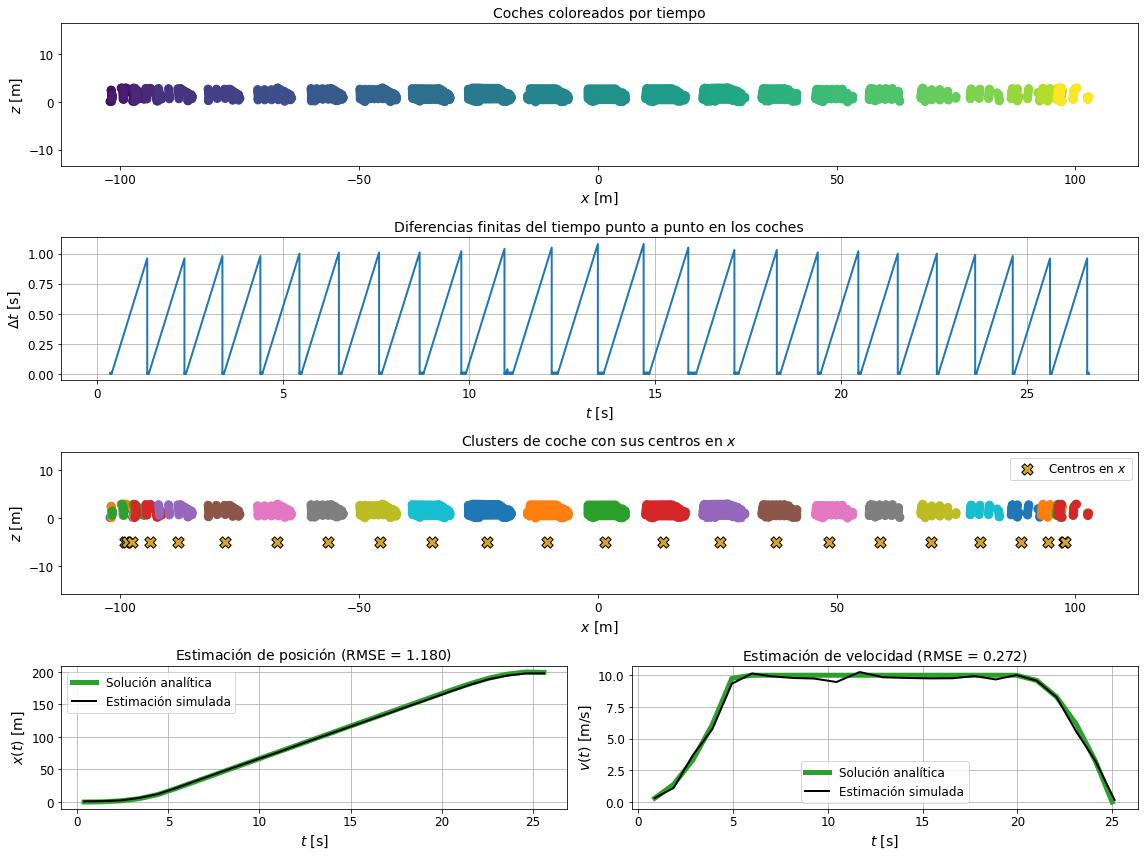

In [15]:
# Extraer puntos de coche ordenados por tiempo y convertir el tiempo a segundos
Pcar = P[P[:, 14] == 2]
Pcar = Pcar[np.argsort(Pcar[:, -1])]
Pcar[:, -1] /= 1e9

# Clusterizar coches por diferencias finitas temporales y extraer centro de cada cluster
Dt = np.diff(Pcar[:, -1])
Dt_th = 0.1  # Cualquier salto temporal superior a Dt_th marca la frontera de un cluster
boundary_indices = np.flatnonzero(Dt > Dt_th)
C = []  # Coches clusterizados, i.e., C[k] son los puntos del k-ésimo cluster
mu_x, mu_t = [], []  # Centros geométricos (en x) y temporales
k, start_idx = 0, 0
for boundary_idx in boundary_indices:
    Ck = Pcar[start_idx:boundary_idx+1]
    Ck = np.hstack([  # (x, y, z, t, k)
        Ck[:, [0, 1, 2, -1]],
        k*np.ones(Ck.shape[0]).reshape(-1, 1)
    ])
    C.append(Ck)
    mu_x.append(np.mean(Ck[:, 0]))
    mu_t.append(np.mean(Ck[:, 3]))
    start_idx = boundary_idx+1
    k += 1
print(f'Se han formado {k} clusters de coche.')
C = np.vstack(C)
mu_x, mu_t = np.array(mu_x), np.array(mu_t)

# Estimar velocidad por diferencias finitas
Dmux = np.diff(mu_x)
Dmut = np.diff(mu_t)
DmuxDmut = Dmux/Dmut
T = np.array([np.mean(mu_t[i:i+2]) for i in range(DmuxDmut.shape[0])])
Tref = np.clip(T, MODELO_t_start, MODELO_t_end)
vT = np.array([v(Ti) for Ti in Tref])  # Solución analítica para la velocidad
RMSE_v = np.sqrt(np.mean(np.square(DmuxDmut-vT)))  # Error en la estimación de velocidad
xt = np.array([x(ti) for ti in mu_t])  # Solución analítica para la posición
RMSE_x = np.sqrt(np.mean(np.square(xt-mu_x-100))) # Error en la estimación de posición

# Preparar figura
fig = plt.figure(figsize=(16, 12))

# Graficar puntos de coche
ax = fig.add_subplot(4, 1, 1)
ax.set_title('Coches coloreados por tiempo', fontsize=14)
ax.scatter(Pcar[:, 0], Pcar[:, 2], c=Pcar[:, -1], s=64, cmap='viridis')
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.axis('equal')

# Graficar diferencias finitas de tiempo
ax = fig.add_subplot(4, 1, 2)
ax.plot(Pcar[:, -1][1:], Dt, color='tab:blue', lw=2)
ax.set_title('Diferencias finitas del tiempo punto a punto en los coches', fontsize=14)
ax.set_xlabel('$t$ [s]', fontsize=14)
ax.set_ylabel('$\Delta t$ [s]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.grid('both')
ax.set_axisbelow(True)

# Graficar clusters y centros 
ax = fig.add_subplot(4, 1, 3)
ax.set_title(r'Clusters de coche con sus centros en $x$', fontsize=14)
ax.scatter(C[:, 0], C[:, 2], c=C[:, 4]%10, s=64, cmap='tab10')
ax.scatter(
    mu_x, -5*np.ones_like(mu_x), s=128, c='goldenrod',
    marker='X', edgecolor='black', linewidths=1, label=r'Centros en $x$'
)
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.axis('equal')
ax.legend(loc='best', fontsize=12)

# Graficar posiciones
ax = fig.add_subplot(4, 2, 7)
ax.set_title(f'Estimación de posición (RMSE = ${{{RMSE_x:.3f}}}$)', fontsize=14)
ax.plot(mu_t, xt, lw=5, color='tab:green', zorder=4, label='Solución analítica')
ax.plot(mu_t, mu_x+100, lw=2, color='black', zorder=5, label='Estimación simulada')
ax.set_xlabel('$t$ [s]', fontsize=14)
ax.set_ylabel('$x(t)$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.grid('both')
ax.set_axisbelow(True)
ax.legend(loc='best', fontsize=12)

# Graficar velocidades
ax = fig.add_subplot(4, 2, 8)
ax.set_title(f'Estimación de velocidad (RMSE = ${{{RMSE_v:.3f}}}$)', fontsize=14)
ax.plot(Tref, vT, lw=5, color='tab:green', zorder=4, label='Solución analítica')
ax.plot(T, DmuxDmut, lw=2, color='black', zorder=5, label='Estimación simulada')
ax.set_xlabel('$t$ [s]', fontsize=14)
ax.set_ylabel('$v(t)$ [m/s]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.grid('both')
ax.set_axisbelow(True)
ax.legend(loc='best', fontsize=12)

# Mostrar figura
fig.tight_layout()
plt.show()

In [12]:
# TODO Remove : Cell
print(mu_x[-2:])
print(len(mu_x))
print(np.clip(T[-2:], MODELO_t_start, MODELO_t_end))

[97.59513609 97.75655049]
24
[24.12093616 25.        ]


### Generando las variaciones de la simulación base

### Realizando el estudio comparativo